In [3]:
import pandas as pd
import numpy as np

# read in main MS dataset
label_file_path = r"Dataset\MS_dataset_v.7.3.csv"
labels_df = pd.read_csv(label_file_path, usecols = ['Local.Participant', 'EDFSCR1L', 'visit.number'])

# Crop down to just the necessary columns
labels_df = labels_df.sort_values(by=['Local.Participant', 'visit.number'])

# shift timepoints and EDSS to get previous as columns
labels_df['Prev_EDSS'] = labels_df.groupby('Local.Participant')['EDFSCR1L'].shift(1)
labels_df['Prev_Timepoint'] = labels_df.groupby('Local.Participant')['visit.number'].shift(1)

# get progression label column
progression_mask = (labels_df['Prev_EDSS'] < 5.0) & (labels_df['EDFSCR1L'] >= 5.0)
labels_df['progression'] = np.where(progression_mask, 1, 0)

transitions = labels_df[progression_mask] # all the data where a transition happens, just in case.

labels_df['Prev_Timepoint'] = labels_df['Prev_Timepoint'].str.upper() # needed for later merges
labels_df['visit.number'] = labels_df['visit.number'].str.upper() # this one is just for consistency

#display(transitions.head(10))

# now that we have a reduced dataset, loop through our weekly dmo aggregations and append the relevant ones to the dataframe
timepoints = ["T1", "T2", "T3", "T4"] # we don't need DMOs where T5 is previous

dfs_list = []
for timepoint in timepoints:
    feature_file_path = f"Dataset/{timepoint} Aggregated DMO Data_V7.3/cvs-{timepoint}-weekly_agg_all-21-01-2026.csv"
    temp_df = pd.read_csv(feature_file_path)
    dfs_list.append(temp_df)

features_df = pd.concat(dfs_list, ignore_index=True)
labels_df = pd.merge(labels_df, features_df, left_on=['Local.Participant', 'Prev_Timepoint'], 
                       right_on = ['participant_id', 'visit_type'], how='left')

labels_df = labels_df.drop(['participant_id', 'visit_type'], axis=1)
labels_df = labels_df.dropna(subset=['Prev_Timepoint'])

# Data cleaning - will monitor number of rows throughout
print(f"Initially {len(labels_df)} rows.")

# get rid of participants with Prev_EDSS > 5 as predicting these is not useful and will mess up our DMO thresholds that the algorithms may learn:
high_prev_edss_mask = (labels_df['Prev_EDSS'] >= 5.0)
print(f"{sum(high_prev_edss_mask)} rows have a previous EDSS > 5 and will be dropped...")
labels_df = labels_df.drop(labels_df[high_prev_edss_mask].index)

# get rid of participants where either current or previous EDSS is missing
count_before = len(labels_df)
labels_df = labels_df.dropna(subset=['EDFSCR1L', 'Prev_EDSS'])
print(f"{count_before - len(labels_df)} rows have missing EDSS values and will be dropped...")

# drop all remaining NAN rows, which will be due to missing DMOs
count_before = len(labels_df)
labels_df = labels_df.dropna()
print(f"{count_before - len(labels_df)} rows have missing DMOs and will be dropped...")

num_transitions = len(labels_df[labels_df["progression"] == 1])
unique_sub_transitions = len(labels_df[labels_df["progression"] == 1]['Local.Participant'].unique())

print(f"We have {num_transitions} transitions across {unique_sub_transitions} subjects, out of a total of {len(labels_df)} valid samples.")

display(labels_df[labels_df["progression"] == 1].head(5))

labels_df.to_csv("data.csv", index=False)

# need to be at least 1 (not 0.5) to change
# subset of EDSS and normalise?
# balance dataset - Done very good

undersampled_df = labels_df.groupby('progression').sample(labels_df.groupby('progression').size().min())

FileNotFoundError: [Errno 2] No such file or directory: 'Dataset\\MS_dataset_v.7.3.csv'

ws_30_avg_w          0.453394
cadence_30_p90_w     0.452577
cadence_30_avg_w     0.446783
ws_30_p90_w          0.444254
ws_10_p90_w          0.394936
wbdur_all_var_w      0.371678
wbsteps_all_sum_w    0.359112
ws_1030_avg_w        0.330151
cadence_all_avg_w    0.317356
walkdur_all_sum_w    0.313035
strdur_30_avg_w      0.301227
wb_60_sum_w          0.282023
wb_30_sum_w          0.259039
strlen_30_avg_w      0.254260
cadence_all_var_w    0.233389
dtype: float64

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

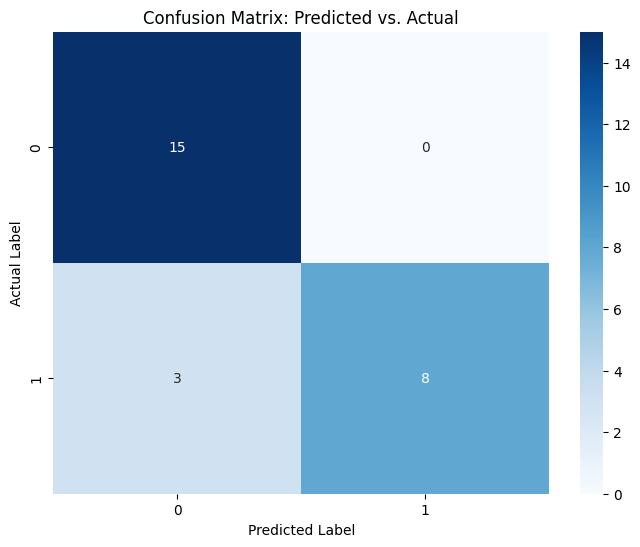

In [115]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import matplotlib.pyplot as plt
import seaborn as sns

# drop irrelevant or 'cheating' columns
labels_y = undersampled_df["progression"].reset_index(drop=True)
labels_X = undersampled_df.drop(["progression", "Local.Participant", "EDFSCR1L", 
                           "visit.number", "Prev_EDSS", "Prev_Timepoint"], axis=1).reset_index(drop=True)

# feature importance analysis
pearson_corr = labels_X.corrwith(labels_y).abs().sort_values(ascending = False).iloc[0:15]

display(pearson_corr)

# train test split
X_train, X_test, y_train, y_test = train_test_split(labels_X, labels_y, test_size=0.2, random_state=42)

# normalisation
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# sample weighting
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model = BayesSearchCV(
    SVC(random_state=42),
    {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),      # Regularization parameter
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),  # Kernel coefficient
        'kernel': Categorical(['rbf', 'poly', 'sigmoid']), # Type of kernel
        'degree': Integer(1, 5)                          # Degree for poly kernel
    },
    n_iter=20,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    cv=5
)

model.fit(X_train, y_train, sample_weight=sample_weights)

# Print the best parameters
print(f"Best Parameters: {model.best_params_}")
print(f"Best Score: {model.best_score_}")

# evaluate
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix: Predicted vs. Actual')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()